##  Python port of code and figures from the book:

# An Introduction to Bayesian Data Analysis for Cognitive Science  
####  https://vasishth.github.io/bayescogsci/book/
## Chapter 3.
## @ Jozsef Arato, University of Vienna 
jozsef.arato@unvie.ac.at

[3.1: Exchangeability and hierarchical models](#3.1)

[3.3: Prior predictive distribution: The N400 effect](#3.3)

[3.5: Revisiting the button-pressing example with different priors](#3.5)

[3.6: Posterior predictive distribution](#3.6)

[3.7: The influence of the likelihood](#3.7)

[3.8: List of the most important commands](#3.8)


In [207]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
import pandas as pd
import pymc as pm
import arviz as az
import seaborn as sns
import time

In [227]:
%precision 3


'%.3f'

 ## 3.1 
 <a id='3.1'></a>

In [3]:
A=4
B=4
N=100
K=80

#### Figure 3.1

alternative for the plot could be using az.plot_posterior(trace)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [theta]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 11 seconds.


Text(0.5, 0, 'theta')

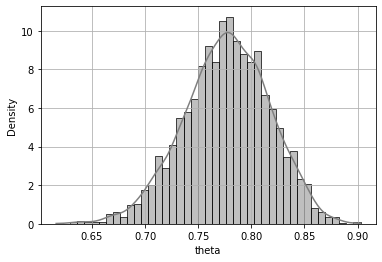

In [44]:
with pm.Model() as ModTheta:
    theta=pm.Beta('theta',alpha=A,beta=B)
    obs=pm.Binomial('likelihood',p=theta,n=N,observed=K)
    trace=pm.sample(2000,chains=2)

fig,ax=plt.subplots()
sns.histplot(np.array(trace.posterior.theta).flatten(),kde=True,ax=ax,color='grey',stat='density')
ax.grid()
ax.set_xlabel('theta')

In [6]:
df_spacebar=pd.read_csv('Data/df_spacebar.csv')

In [47]:
df_spacebar

,Unnamed: 0,t,trial
0,1,141,1
1,2,138,2
2,3,128,3
3,4,132,4
4,5,126,5
...,...,...,...
356,357,182,357
357,358,179,358
358,359,177,359
359,360,183,360


#### FIGURE 3.2
Visualizing the button-press data.



Text(0.5, 1.0, 'Button-press data')

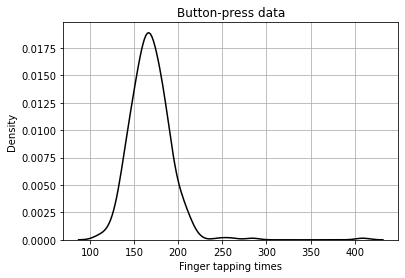

In [52]:
fig,ax=plt.subplots()
sns.kdeplot(df_spacebar['t'],ax=ax,color='k')
ax.set_xlabel('Finger tapping times')
ax.grid()
ax.set_title('Button-press data')

3.2.1.1 Specifying the model in pymc


In [49]:
with pm.Model() as fit_press:
    b_intercept=pm.Uniform('b_intercept',0,60000)
    sigma=pm.Uniform('sigma',0,2000)
    likelihood=pm.Normal('likelihood',mu=b_intercept,sigma=sigma,observed=df_spacebar['t'])
    trace_press=pm.sample(chains=4,tune=1000,draws=1000,discard_tuned_samples=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b_intercept, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 24 seconds.


#### Figure 3.3a. Model that converged

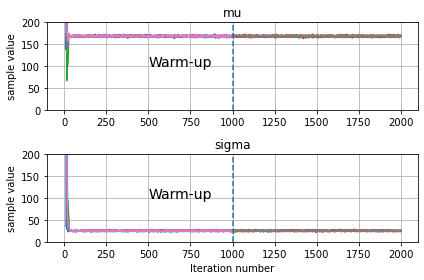

In [106]:
fig,ax=plt.subplots(nrows=2)
for n in range(4):
    ax[0].plot(trace_press.warmup_posterior.b_intercept[n,:])
    ax[1].plot(trace_press.warmup_posterior.sigma[n,:])
    ax[0].plot(np.arange(1000,2000),trace_press.posterior.b_intercept[n,:])
    ax[1].plot(np.arange(1000,2000),trace_press.posterior.sigma[n,:])
    ax[0].set_ylabel('sample value')
    ax[1].set_ylabel('sample value')
    ax[0].set_title('mu')
    ax[1].set_title('sigma')

ax[1].set_xlabel('Iteration number')

for i in range(2):
    ax[i].axvline(1000,linestyle='--')
    ax[i].grid()
    ax[i].text(500,100,'Warm-up',fontsize=14)
    ax[i].set_ylim([0,200])
plt.tight_layout()

#### Figure 3.3b

there are many different ways to create problems with sampling, but I did not manage to create one that is very similar to the book. 



3.2.1.3 Output of pymc

In [110]:
trace_press.posterior

<xarray.Dataset>
Dimensions:      (chain: 4, draw: 1000)
Coordinates:
  * chain        (chain) int64 0 1 2 3
  * draw         (draw) int64 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
Data variables:
    b_intercept  (chain, draw) float64 169.1 167.9 169.3 ... 170.2 166.7 170.4
    sigma        (chain, draw) float64 24.87 25.49 25.78 ... 24.04 25.37 23.77
Attributes:
    created_at:                 2023-07-28T15:43:34.351358
    arviz_version:              0.14.0
    inference_library:          pymc
    inference_library_version:  5.0.1
    sampling_time:              18.79413414001465
    tuning_steps:               1000

### Figure 3.4

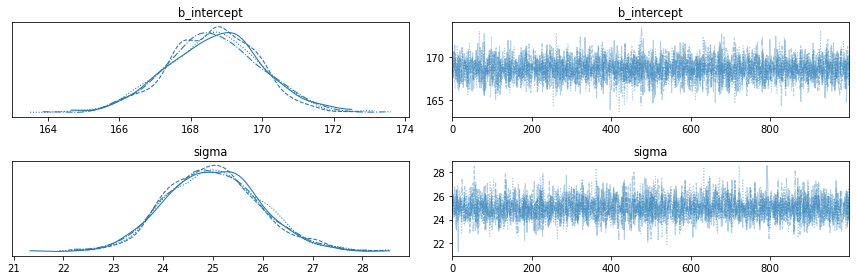

In [119]:
az.plot_trace(trace_press)
plt.tight_layout()

In [120]:
az.summary(trace_press)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b_intercept,168.653,1.318,166.061,171.023,0.021,0.015,4034.0,2650.0,1.0
sigma,25.009,0.929,23.341,26.807,0.015,0.011,3758.0,2785.0,1.0


## 3.3  Prior predictive distribution
 <a id='3.3'></a>

In [4]:
def normal_predictive_distribution(mu_samples, sigma_samples, N_obs):
    df_pred=pd.DataFrame(columns=['trialn','t_pred','iter'])
    for i,musigm in enumerate(zip(mu_samples, sigma_samples)):
        df=pd.DataFrame()
        df['trialn']=np.arange(N_obs) 
        df['t_pred']=np.random.normal(musigm[0],musigm[1],N_obs)
        df['iter']=i
        df_pred=pd.concat([df_pred,df],ignore_index=True)
    return df_pred

In [8]:
N_samples = 1000
N_obs = len(df_spacebar)
mu_samples = np.random.uniform(0, 60000,N_samples)
sigma_samples=np.random.uniform( 0, 2000,N_samples)

In [163]:
normal_predictive_distribution(mu_samples,sigma_samples,N_obs)

,trialn,t_pred,iter
0,0,23917.950861,0
1,1,26832.476797,0
2,2,22267.275101,0
3,3,22186.760918,0
4,4,25909.590479,0
...,...,...,...
360995,356,36607.701581,999
360996,357,39778.081079,999
360997,358,37013.140882,999
360998,359,39419.675395,999


In [9]:
st = time.time()
normal_predictive_distribution(mu_samples,sigma_samples,N_obs)
print(f'{time.time()-st:.2f} sec elapsed')


4.88 sec elapsed


### Box 3.1 -- a more efficient function for prior predicitve 

a simple way to speed up the code is to combine the data in numpy , and only put it into a  large dataframe at the end  (this is not the same way of speeding up the code as in the book)

In [10]:
def normal_predictive_distribution(mu_samples, sigma_samples, N_obs):
    xx=np.zeros((0,3))
    for i,musigm in enumerate(zip(mu_samples, sigma_samples)):
        x=np.column_stack((np.arange(N_obs),np.random.normal(musigm[0],musigm[1],N_obs),np.full(N_obs,i)))        
        xx=np.vstack((xx,x))
    return pd.DataFrame(data=xx,columns=['trialn','t_pred','iter'])

In [14]:
pred=normal_predictive_distribution(mu_samples,sigma_samples,N_obs)
pred

,trialn,t_pred,iter
0,0.0,33530.010233,0.0
1,1.0,33556.972267,0.0
2,2.0,33450.391375,0.0
3,3.0,33394.166114,0.0
4,4.0,33789.795654,0.0
...,...,...,...
360995,356.0,17842.133897,999.0
360996,357.0,19380.006579,999.0
360997,358.0,17522.552936,999.0
360998,359.0,19255.335047,999.0


with the below, the M1 Macbook Air is 4 times as fast as the Lenovo core i5,

In [15]:
st = time.time()
normal_predictive_distribution(mu_samples,sigma_samples,N_obs)  
print(f'{time.time()-st:.2f} sec elapsed')


1.30 sec elapsed


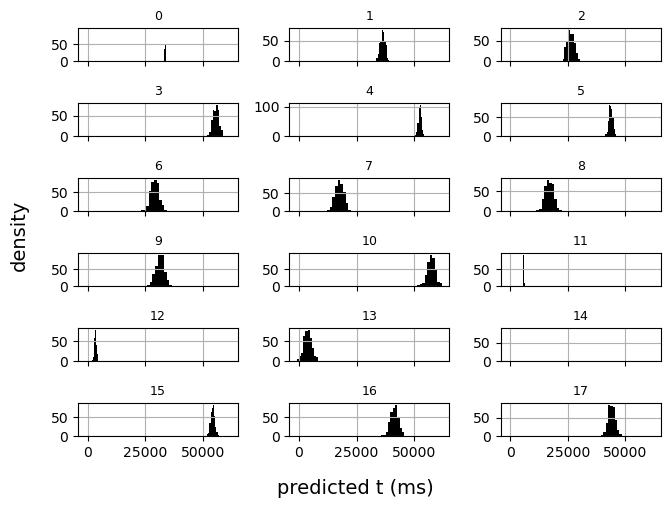

In [26]:
fig,ax=plt.subplots(ncols=3,nrows=6,sharex=True)
ax=ax.flatten()
for ce in range(len(ax)):
    ax[ce].hist(pred['t_pred'][pred['iter']==ce],color='k')
    ax[ce].set_title(ce,fontsize=9)
    ax[ce].grid()
fig.text(0.5, -0.04,'predicted t (ms)', ha='center',fontsize=14)
fig.text(-0.04,0.5,'density', va='center',fontsize=14,rotation=90)

plt.tight_layout()

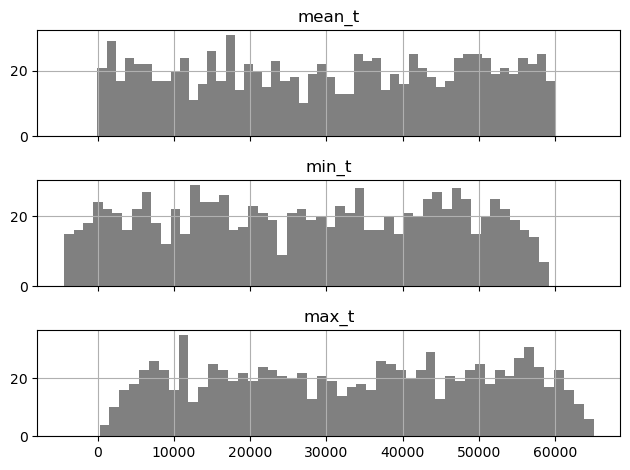

In [44]:
fig,ax=plt.subplots(nrows=3,sharex=True)
measures=['mean','min','max']

ax[0].hist(pred['t_pred'].groupby(pred['iter']).mean(),bins=50,color='gray')
ax[1].hist(pred['t_pred'].groupby(pred['iter']).min(),bins=50,color='gray')
ax[2].hist(pred['t_pred'].groupby(pred['iter']).max(),bins=50,color='gray')

for ce in range(3):
    ax[ce].set_title(measures[ce]+'_t')
    ax[ce].grid()
plt.tight_layout()    

## 3.5  Revisiting the button-pressing example with different priors

 <a id='3.5'></a>

In [57]:
with pm.Model() as fit_press_unif:
    b_intercept=pm.Uniform('b_intercept',-60000,60000)
    sigma=pm.Uniform('sigma',0,60000)
    likelihood=pm.Normal('likelihood',mu=b_intercept,sigma=sigma,observed=df_spacebar['t'])
    trace_press_unif=pm.sample(chains=4,tune=1000,draws=1000,discard_tuned_samples=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b_intercept, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 25 seconds.


In [47]:
az.summary(trace_press_unif)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b_intercept,168.638,1.308,166.173,171.111,0.020,0.014,4178.0,2660.0,1.0
sigma,25.002,0.953,23.352,26.945,0.015,0.011,4030.0,2884.0,1.0


#### FIGURE 3.7

<AxesSubplot: title={'center': 'sigma'}>

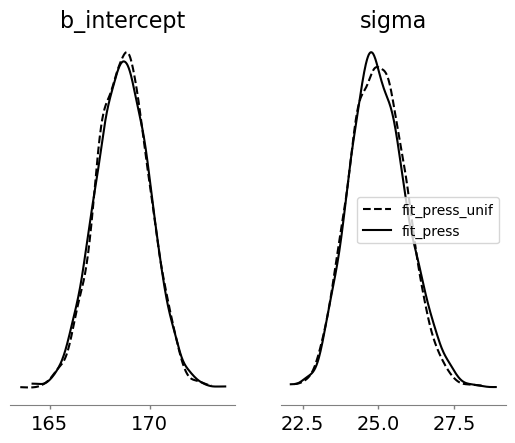

In [60]:
fig,ax=plt.subplots(ncols=2)
az.plot_posterior(trace_press_unif.posterior.b_intercept,ax=ax[0],hdi_prob='hide',color='k',linestyle='--',point_estimate=None)
az.plot_posterior(trace_press.posterior.b_intercept,ax=ax[0],hdi_prob='hide',color='k',point_estimate=None)

az.plot_posterior(trace_press_unif.posterior.sigma,ax=ax[1],hdi_prob='hide',color='k',linestyle='--',point_estimate=None,label='fit_press_unif')
az.plot_posterior(trace_press.posterior.sigma,ax=ax[1],hdi_prob='hide',color='k',point_estimate=None,label='fit_press')

In [61]:
with pm.Model() as fit_press_inf:
    b_intercept=pm.Normal('b_intercept',400,10)
    sigma=pm.Normal('sigma',100,10)
    likelihood=pm.Normal('likelihood',mu=b_intercept,sigma=sigma,observed=df_spacebar['t'])
    trace_press_inf=pm.sample(chains=4,tune=1000,draws=1000,discard_tuned_samples=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b_intercept, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 25 seconds.


In [62]:
az.summary(trace_press_inf)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b_intercept,172.942,1.388,170.180,175.419,0.022,0.016,3817.0,3313.0,1.0
sigma,26.065,1.067,24.129,28.109,0.018,0.013,3727.0,2806.0,1.0


In [63]:
with pm.Model() as fit_press_prin :
    b_intercept=pm.Normal('b_intercept',200,100)
    sigma=pm.Normal('sigma',50,50)
    likelihood=pm.Normal('likelihood',mu=b_intercept,sigma=sigma,observed=df_spacebar['t'])
    trace_press_prin=pm.sample(chains=4,tune=1000,draws=1000,discard_tuned_samples=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b_intercept, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 23 seconds.


In [64]:
az.summary(trace_press_prin)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b_intercept,168.625,1.327,165.994,170.980,0.023,0.016,3347.0,3035.0,1.0
sigma,25.009,0.927,23.245,26.728,0.015,0.011,3883.0,3082.0,1.0


## 3.6 Posterior predictive distribution

 <a id='3.6'></a>

In [72]:
N_samples = 1000
N_obs = len(df_spacebar)
mu_samples = np.array(trace_press.posterior.b_intercept).flatten() # from the first chain
sigma_samples= np.array(trace_press.posterior.sigma).flatten() # from the first chain

In [73]:
pred=normal_predictive_distribution(mu_samples,sigma_samples,N_obs)


In [322]:
pred.head()

,trialn,t_pred,iter
0,0.000,181.043,0.000
1,1.000,165.565,0.000
2,2.000,154.550,0.000
3,3.000,183.852,0.000
4,4.000,156.080,0.000


#### posterior predictive with pymc

In [78]:
with fit_press:
    pm.sample_posterior_predictive(trace=trace_press, extend_inferencedata=True)

Sampling: [likelihood]


#### FIGURE 3.8

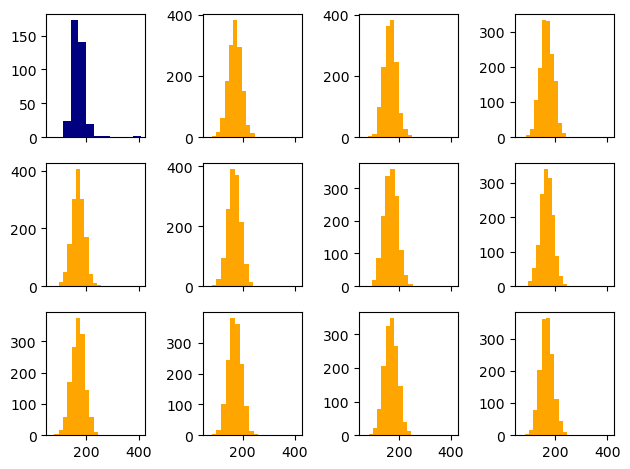

In [101]:
fig,ax=plt.subplots(nrows=3,ncols=4,sharex=True)
ax=ax.flatten()
ax[0].hist(df_spacebar['t'],color='navy')
for i in np.arange(11):
    ax[i+1].hist(np.array(trace_press.posterior_predictive.likelihood[:,i,:]).flatten(),color='orange')
plt.tight_layout()


In [95]:
trace_press.posterior_predictive.likelihood

<xarray.DataArray 'likelihood' (chain: 4, draw: 1000, likelihood_dim_2: 361)>
array([[[235.71073694, 167.00259064, 152.69562121, ..., 157.09308272,
         136.22723418, 169.21493071],
        [236.06501842, 169.11446068, 183.98945601, ..., 196.80228996,
         170.43445055, 150.90811499],
        [117.05547803, 172.96297018, 149.44901807, ..., 156.93547792,
         138.18187666, 190.56877055],
        ...,
        [173.25016629, 168.19893157, 148.14822297, ..., 185.07014829,
         171.22159407, 204.87540748],
        [153.59422291, 198.98889464, 194.96600907, ..., 170.60301378,
         142.7920666 , 168.89038697],
        [220.85067863, 233.11667786, 169.77994291, ..., 141.27458012,
         136.97808528, 137.47499588]],

       [[140.51025725, 189.32132912, 171.19952859, ..., 208.60530685,
         196.20084777, 219.44409366],
        [239.1584748 , 176.30827856, 157.22865894, ..., 117.89715539,
         175.48869196, 193.0390219 ],
        [188.23091086, 185.87786924, 188.09395077, ..., 141.33925889,
         157.00791347, 197.24529338],
...
        [183.39213672, 142.63260999, 161.02499889, ..., 251.45008311,
         126.64107723, 171.45250731],
        [144.05024556, 128.08893   , 192.22079164, ..., 214.47491089,
         199.29875191, 156.85891245],
        [181.33594674, 133.48553248, 154.48691272, ..., 157.20653825,
         200.61917378, 169.33937561]],

       [[168.94181467, 194.28957115, 163.86290643, ..., 230.60345187,
         193.27837646, 154.28351372],
        [168.15742616, 145.18675183, 183.13271867, ..., 153.53664839,
         185.7915007 , 174.18355293],
        [131.00462382, 186.23578801, 144.5877784 , ..., 195.76401895,
         169.33391556, 146.29596645],
        ...,
        [158.22846273, 155.13779071, 162.46854552, ..., 171.30619593,
         137.89111907, 150.06124161],
        [191.32279946, 166.31773533, 189.55869292, ..., 175.87494104,
         167.89613916, 141.20046405],
        [128.46381007, 163.78668416, 154.76751696, ..., 177.03148584,
         150.77673258, 139.37981242]]])
Coordinates:
  * chain             (chain) int32 0 1 2 3
  * draw              (draw) int32 0 1 2 3 4 5 6 ... 993 994 995 996 997 998 999
  * likelihood_dim_2  (likelihood_dim_2) int32 0 1 2 3 4 ... 356 357 358 359 360

#### FIGURE 3.9

<AxesSubplot: xlabel='likelihood / likelihood'>

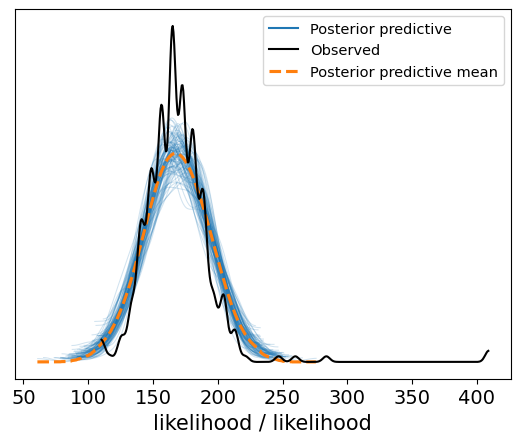

In [102]:
az.plot_ppc(trace_press,num_pp_samples=100)

## 3.7 The influence of the likelihood

 <a id='3.7'></a>

### 3.7.1 The log-normal likelihood

only the second method produces the same result, as scipy lognorm is parametrized differently - mu is the actual mean of the lognormal, not the exp(normal). 

In [151]:
mu = 6
sigma = 0.5
N = 5000
s = .9
v1=stats.lognorm.rvs(s,loc=mu,scale=sigma,size=N)
v2=np.exp(stats.norm.rvs(loc=mu,scale=sigma,size=N))


#### Figure 3.10

Text(0.5, 1.0, 'Log-norm  exp(norm(6,.5))')

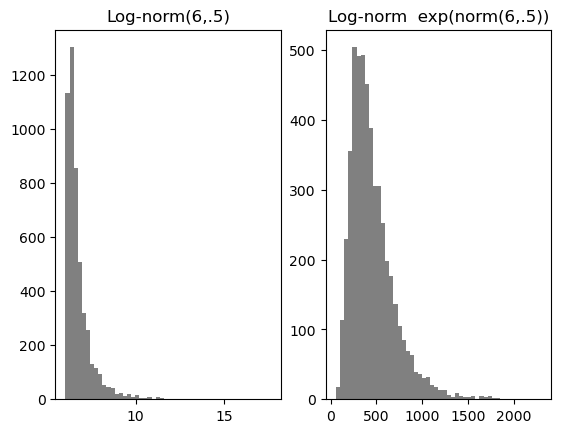

In [152]:
          
fig,ax=plt.subplots(ncols=2)
yy=ax[0].hist(v1,bins=50,color='gray')
ax[0].set_title('Log-norm(6,.5)')
yy=ax[1].hist(v2,bins=50,color='gray')
ax[1].set_title('Log-norm  exp(norm(6,.5))')



### 3.7.2 Using a log-normal likelihood to fit data from a single subject pressing a button repeatedly

In [173]:
N_samples = 1000
N_obs = len(df_spacebar)
mu_samples =  np.random.uniform(0, 11,N_samples)
sigma_samples =  np.random.uniform( 0, 1,N_samples)
prior_pred_ln = normal_predictive_distribution(
  mu_samples = mu_samples,
  sigma_samples = sigma_samples,
  N_obs = N_obs
) 

In [174]:
prior_pred_ln['t_pred']=np.exp(prior_pred_ln['t_pred'])

#### FIGURE 3.11 

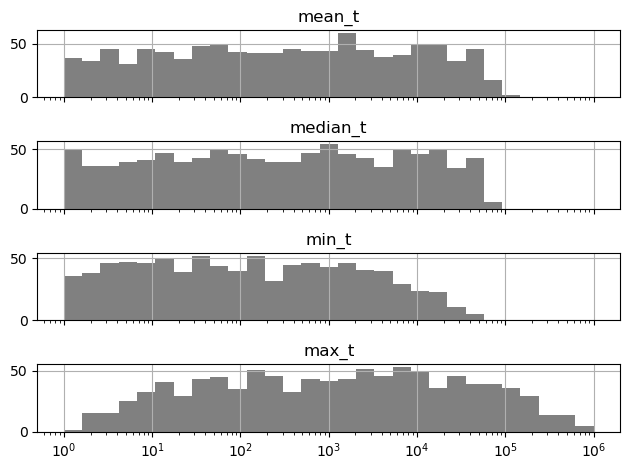

In [183]:
measures=['mean','median','min','max']
fig,ax=plt.subplots(nrows=len(measures),sharex=True)

bins=10**(np.linspace(0,6,30))

ax[0].hist(prior_pred_ln['t_pred'].groupby(prior_pred_ln['iter']).mean(),color='gray',bins=bins)
#plt.xscale('log')

ax[1].hist(prior_pred_ln['t_pred'].groupby(prior_pred_ln['iter']).median(),color='gray',bins=bins)
ax[2].hist(prior_pred_ln['t_pred'].groupby(prior_pred_ln['iter']).min(),color='gray',bins=bins)
ax[3].hist(prior_pred_ln['t_pred'].groupby(prior_pred_ln['iter']).max(),color='gray',bins=bins)

for ce in range(len(measures)):
    ax[ce].set_title(measures[ce]+'_t')
    ax[ce].grid()
    ax[ce].set_xscale('log')

plt.tight_layout()   

In [228]:
np.mean(stats.truncnorm(a=0,b=np.inf).rvs(10000))   # truncated normal requires upper limit b

0.795

In [226]:
CI={}
CI['lower']=np.exp(6 - 2 * 1.5)
CI['higher']=np.exp(6 + 2 * 1.5)
CI

{'lower': 20.086, 'higher': 8103.084}

In [260]:
with pm.Model() as press_lognorm:
    b_intercept=pm.Normal('b_intercept',6,1.5)
    sigma=pm.HalfNormal('sigma',1)
    likelihood=pm.LogNormal('likelihood',mu=b_intercept,sigma=sigma,observed=df_spacebar['t'])
    prior_lognorm=pm.sample_prior_predictive()


Sampling: [b_intercept, likelihood, sigma]


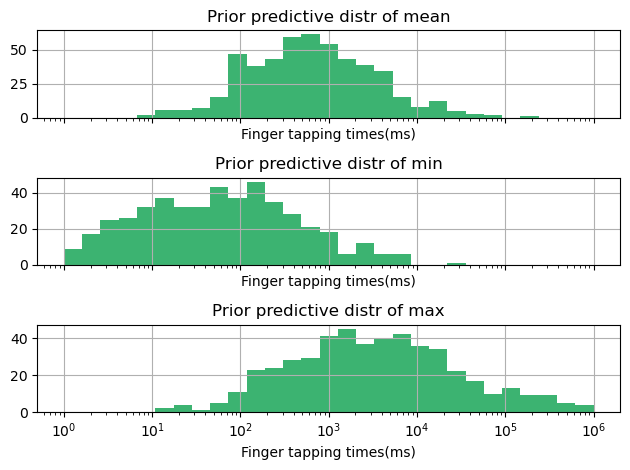

In [261]:
measures=['mean','min','max']
fig,ax=plt.subplots(nrows=len(measures),sharex=True)
ax[0].hist(np.mean(prior_lognorm.prior_predictive.likelihood[0,:,:],1),bins=bins,color='mediumseagreen')
ax[1].hist(np.min(prior_lognorm.prior_predictive.likelihood[0,:,:],1),bins=bins,color='mediumseagreen')
ax[2].hist(np.max(prior_lognorm.prior_predictive.likelihood[0,:,:],1),bins=bins,color='mediumseagreen')

for m in range(len(measures)):
    ax[m].set_xscale('log')
    ax[m].set_xlabel('Finger tapping times(ms)')
    ax[m].set_title(f'Prior predictive distr of {measures[m]}')
    ax[m].grid()
plt.tight_layout()

since we already  defined it above, it is really short to fit it

In [262]:
with press_lognorm:
    trace_press_lognorm=pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b_intercept, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 24 seconds.


In [263]:
az.summary(trace_press_lognorm)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b_intercept,5.118,0.007,5.105,5.132,0.000,0.000,"3,826.000","3,009.000",1.000
sigma,0.135,0.005,0.125,0.144,0.000,0.000,"3,830.000","2,126.000",1.000


In [270]:
estimate_ms=np.exp(trace_press_lognorm.posterior.b_intercept)

In [279]:
print('mean',np.mean(np.array(estimate_ms)))
print('percentile',np.percentile(estimate_ms,[.025,97.5]))
print(az.hdi(estimate_ms,hdi_prob=.95))
## please note the difference between HDI and percentile (can be more different for assymetric distributions)

mean 167.07407104953379
percentile [163.204 169.414]
<xarray.Dataset>
Dimensions:      (hdi: 2)
Coordinates:
  * hdi          (hdi) <U6 'lower' 'higher'
Data variables:
    b_intercept  (hdi) float64 164.9 169.5


#### FIGURE 3.13

In [286]:
with press_lognorm:
    pm.sample_posterior_predictive(trace=trace_press_lognorm,extend_inferencedata=True)



Sampling: [likelihood]


<AxesSubplot: xlabel='likelihood / likelihood'>

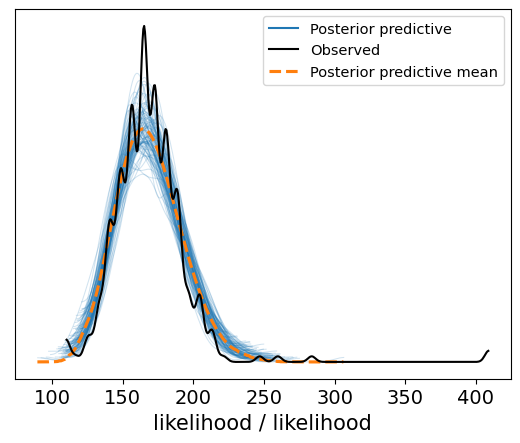

In [287]:
az.plot_ppc(trace_press_lognorm,num_pp_samples=100)

#### FIGURE 3.14

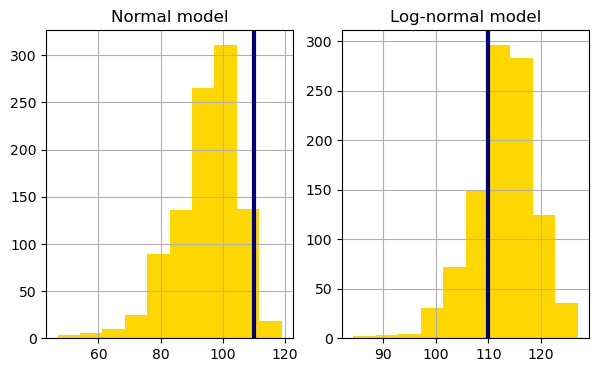

In [303]:
fig,ax=plt.subplots(ncols=2,figsize=(7,4))
Titles=['Normal model','Log-normal model']
ax[0].hist(np.min(trace_press.posterior_predictive.likelihood[0,:,:],1),color='gold')
ax[1].hist(np.min(trace_press_lognorm.posterior_predictive.likelihood[0,:,:],1),color='gold')
for a in range(2):
    ax[a].axvline(np.min(df_spacebar['t']),color='navy',linewidth=3)
    ax[a].grid()
    ax[a].set_title(Titles[a])

#### FIGURE 3.15

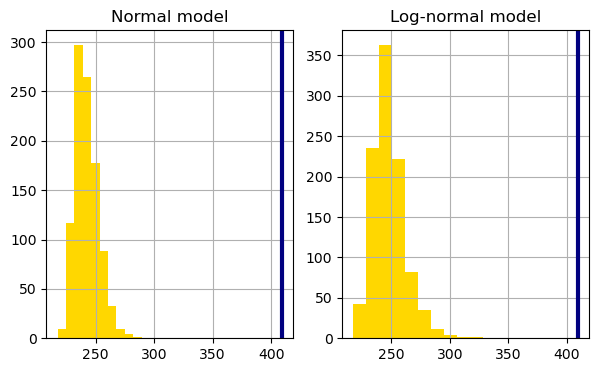

In [304]:
fig,ax=plt.subplots(ncols=2,figsize=(7,4))
ax[0].hist(np.max(trace_press.posterior_predictive.likelihood[0,:,:],1),color='gold')
ax[1].hist(np.max(trace_press_lognorm.posterior_predictive.likelihood[0,:,:],1),color='gold')
for a in range(2):
    ax[a].axvline(np.max(df_spacebar['t']),color='navy',linewidth=3)
    ax[a].grid()
    ax[a].set_title(Titles[a])

##  3.8 List of the most important commands

 <a id='3.8'></a>

the core of a simple pymc mopdel fit

In [307]:
with pm.Model() as fit_press:
    b_intercept=pm.Uniform('b_intercept',0,60000)
    sigma=pm.Uniform('sigma',0,2000)
    likelihood=pm.Normal('likelihood',mu=b_intercept,sigma=sigma,observed=df_spacebar['t'])
   

extend basic pymc model with prior and posterior checks

In [310]:
with fit_press:
    trace_press=pm.sample_prior_predictive()
    trace_press.extend(pm.sample(chains=4,draws=1000))
    pm.sample_posterior_predictive(trace=trace_press,extend_inferencedata=True)


Sampling: [b_intercept, likelihood, sigma]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b_intercept, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 25 seconds.
Sampling: [likelihood]


using the above, the same inferencedata object contains :
1. prior_predictive
2. posterior
3. posterior predictive 
samples

additonaly separating model definition from fitting can be useful for debugging



In [311]:
trace_press

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> prior
	> prior_predictive
	> observed_data

##### access prior predictive samples:

In [313]:
trace_press.prior_predictive.likelihood

<xarray.DataArray 'likelihood' (chain: 1, draw: 500, likelihood_dim_0: 361)>
array([[[40142.592, 42947.312, 41550.819, ..., 41652.61 , 42574.721,
         41167.65 ],
        [42175.621, 42252.032, 41981.945, ..., 41915.212, 41480.633,
         41409.757],
        [48626.847, 49924.162, 50765.577, ..., 48819.377, 47606.744,
         51582.791],
        ...,
        [36393.844, 37903.835, 37173.529, ..., 36571.283, 36791.482,
         37304.423],
        [32937.141, 32786.975, 32766.505, ..., 33016.664, 32925.312,
         32712.706],
        [24946.977, 22573.911, 24053.68 , ..., 25458.717, 23242.628,
         24338.481]]])
Coordinates:
  * chain             (chain) int32 0
  * draw              (draw) int32 0 1 2 3 4 5 6 ... 493 494 495 496 497 498 499
  * likelihood_dim_0  (likelihood_dim_0) int32 0 1 2 3 4 ... 356 357 358 359 360

#### access posterior samples:

In [317]:
trace_press.posterior.b_intercept
trace_press.posterior.sigma

<xarray.DataArray 'sigma' (chain: 4, draw: 1000)>
array([[24.507, 24.568, 24.568, ..., 23.379, 26.02 , 25.78 ],
       [24.841, 24.235, 25.664, ..., 23.924, 23.924, 23.255],
       [24.548, 25.322, 25.556, ..., 25.095, 24.738, 24.498],
       [25.686, 25.539, 25.911, ..., 23.798, 25.091, 25.091]])
Coordinates:
  * chain    (chain) int32 0 1 2 3
  * draw     (draw) int32 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999

##### access posterior predictive samples:

In [318]:
trace_press.posterior_predictive.likelihood

<xarray.DataArray 'likelihood' (chain: 4, draw: 1000, likelihood_dim_2: 361)>
array([[[177.151, 161.232, 180.311, ..., 194.464, 208.16 , 143.835],
        [179.052, 176.95 , 123.311, ..., 202.877, 177.586, 177.273],
        [147.071, 159.484, 159.998, ..., 186.94 , 160.875, 151.252],
        ...,
        [163.256, 197.71 , 231.783, ..., 178.63 , 152.963, 144.443],
        [161.748, 135.207, 205.05 , ..., 146.686, 194.222, 175.244],
        [175.637, 181.726, 188.376, ..., 151.305, 129.301, 156.74 ]],

       [[144.196, 179.435, 161.038, ..., 149.15 , 152.566, 161.654],
        [199.654, 180.701, 174.226, ..., 177.903, 136.105, 148.422],
        [225.898, 178.329, 156.05 , ..., 157.56 , 128.571, 166.347],
        ...,
        [193.264, 199.662, 145.484, ..., 179.907, 193.905, 164.017],
        [157.207, 184.997, 207.391, ..., 197.054, 180.183, 161.747],
        [190.034, 161.233, 163.953, ..., 156.088, 161.315, 149.109]],

       [[202.545, 154.204, 165.296, ..., 171.15 , 154.071, 153.352],
        [197.086, 118.553, 217.227, ..., 156.397, 210.969, 205.453],
        [147.077, 152.185, 158.792, ..., 155.621, 162.07 , 178.929],
        ...,
        [147.425, 124.971, 150.955, ..., 114.534, 163.451, 158.621],
        [185.28 , 174.371, 194.852, ..., 150.054, 143.303, 175.083],
        [168.487, 149.518, 181.885, ..., 134.372, 168.414, 182.505]],

       [[163.975, 143.816, 142.41 , ..., 152.611, 129.54 , 216.227],
        [163.277,  98.824, 177.88 , ..., 201.76 , 200.011, 169.781],
        [235.974, 203.483, 146.797, ..., 201.857, 182.861, 136.676],
        ...,
        [179.023, 185.202, 150.467, ..., 163.018, 155.4  , 178.625],
        [166.512, 185.163, 152.626, ..., 179.326, 158.873, 117.399],
        [169.851, 154.66 , 158.75 , ..., 171.685, 197.481, 158.394]]])
Coordinates:
  * chain             (chain) int32 0 1 2 3
  * draw              (draw) int32 0 1 2 3 4 5 6 ... 993 994 995 996 997 998 999
  * likelihood_dim_2  (likelihood_dim_2) int32 0 1 2 3 4 ... 356 357 358 359 360

array([<AxesSubplot: title={'center': 'b_intercept'}>,
       <AxesSubplot: title={'center': 'sigma'}>], dtype=object)

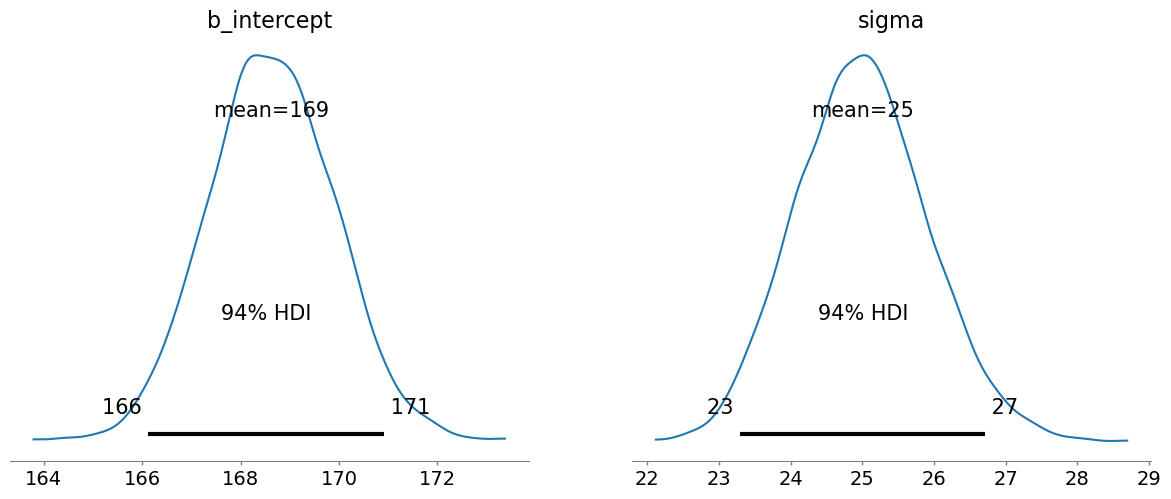

In [321]:
az.plot_posterior(trace_press)

<AxesSubplot: xlabel='likelihood / likelihood'>

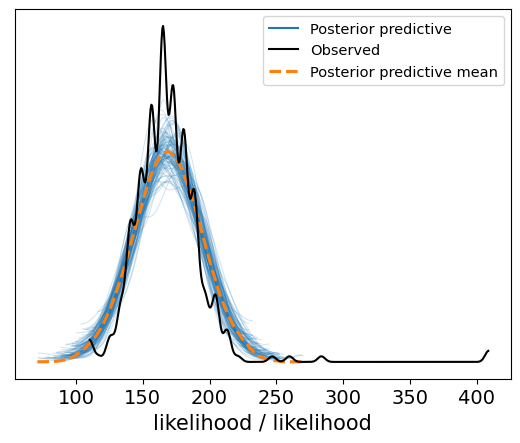

In [320]:
az.plot_ppc(trace_press,num_pp_samples=100)